# New York City Boroughs Landcover Analysis

### Introduction

New York City, also known as the concrete jungle, isn't well know for having much green in the city aside from central park. Using landsat imagery we can analyze the surface of each borough in NYC and determine how much of the city is concrete, and how much is greenery. 

To do this I'll use Normalized Difference Vegetation index (NDVI) to categorize the surfaces level colors into values.

<img src="ndvi.png" alt="Drawing" style="width: 500px;"/>

### Imports

In [3]:
import pandas as pd
from datetime import datetime
from IPython.display import Image
from IPython.display import HTML
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import matplotlib.pyplot as plt
import arcgis
import sys
from arcgis.gis import GIS
from arcgis.raster.functions import apply, clip, remap, colormap
from arcgis.geometry import lengths, areas_and_lengths, project
from arcgis.geometry import Point, Polyline, Polygon, Geometry
from arcgis.geocoding import geocode
from arcgis.features import FeatureLayer
gis = GIS()
nyc = gis.map('New York City')
nyc

MapView(layout=Layout(height='400px', width='100%'))

In [4]:
landsat_item = gis.content.search('title:Multispectral Landsat', 'Imagery Layer', outside_org=True)[0]
landsat = landsat_item.layers[0]
landsat_item

<Item title:"Multispectral Landsat (Mature Support)" type:Imagery Layer owner:esri>

### NYC boroughs spatial data from ny.gov

### Landsat image of NYC

In [5]:
area = geocode("New York City", out_sr=landsat.properties.spatialReference)[0]
landsat.extent = area['extent']
selected = landsat.filter_by(where="(Category = 1) AND (cloudcover <=0.05)",
                            time=[datetime(2020, 4, 1), datetime(2020, 6, 30)],
                             geometry=arcgis.geometry.filters.intersects(area['extent']))

df = selected.query(out_fields="AcquisitionDate, GroupName, CloudCover, DayOfYear", 
                    order_by_fields="AcquisitionDate").sdf
df['AcquisitionDate'] = pd.to_datetime(df['AcquisitionDate'], unit='ms')
df

,OBJECTID,AcquisitionDate,GroupName,CloudCover,DayOfYear,Shape_Length,Shape_Area,SHAPE
0,3372200,2020-05-12 15:33:06,LC80130322020133LGN00_MTL,0.0255,133,978733.926547,5.982305e+10,"{""rings"": [[[-8017116.856699999, 5007538.59269..."


In [6]:
nyc_image = landsat.filter_by('OBJECTID=3372200')

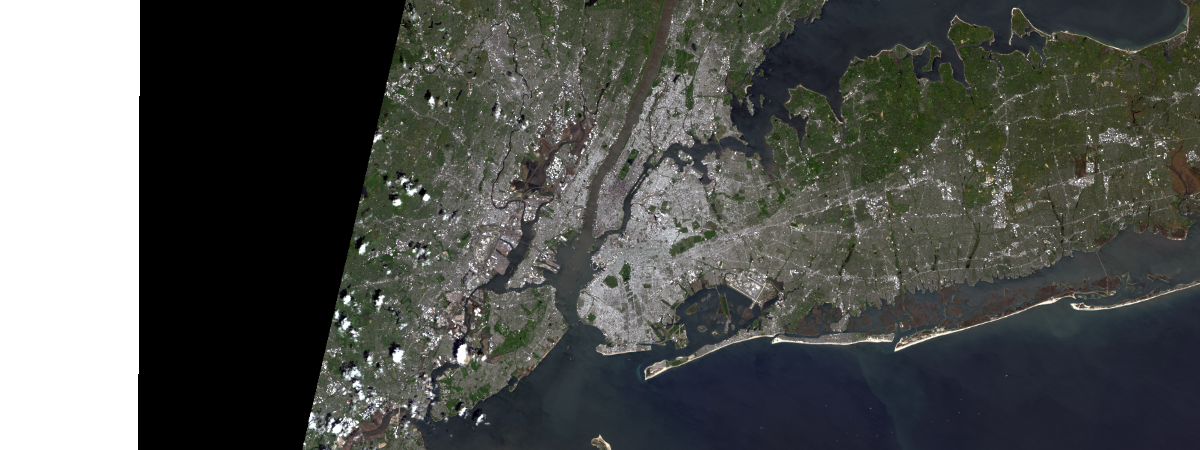

In [7]:
apply(nyc_image, 'Natural Color with DRA')

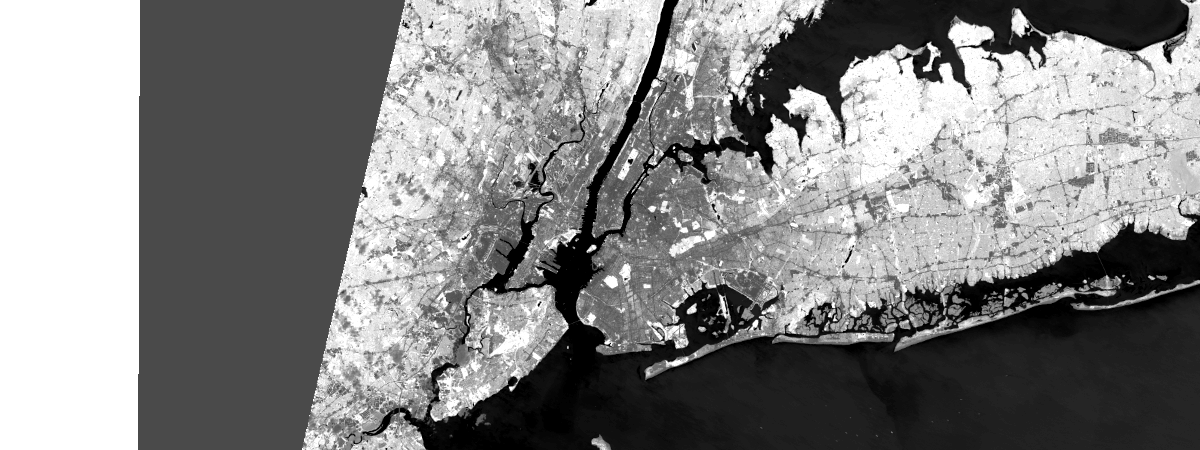

In [8]:
nyc_colorized = apply(nyc_image, 'NDVI Raw')
nyc_colorized

### NDVI color mask

In [9]:
boroughs = FeatureLayer('https://gisservices.its.ny.gov/arcgis/rest/services/NYS_Civil_Boundaries/FeatureServer/2')
nh_df = pd.DataFrame.spatial.from_layer(boroughs)
#Brooklyn
bk_df = nh_df.loc[nh_df['NAME'] == 'Kings']
#Staten Island
si_df = nh_df.loc[nh_df['NAME'] == 'Richmond']
#Manhattan
m_df = nh_df.loc[nh_df['NAME'] == 'New York']
#The Bronx
tb_df = nh_df.loc[nh_df['NAME'] == 'Bronx']
#Queens
q_df = nh_df.loc[nh_df['NAME'] == 'Queens']

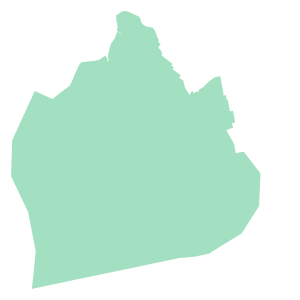

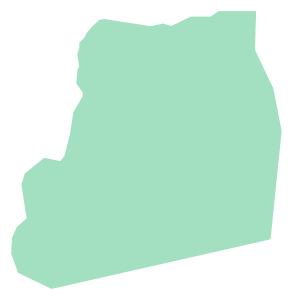

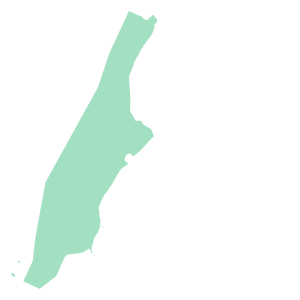

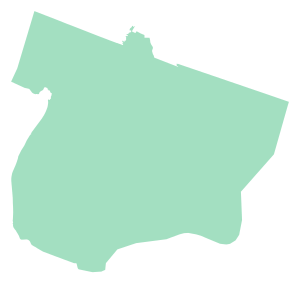

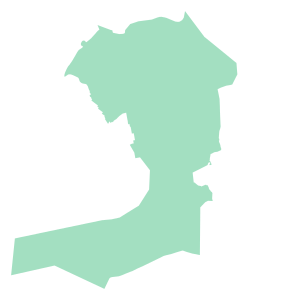

In [10]:
display(bk_df.spatial)
display(si_df.spatial)
display(m_df.spatial)
display(tb_df.spatial)
display(q_df.spatial)

In [18]:
def all_together(df, name):

    def land_clip(df):
        global shape
        global poly
        global masked
        poly = df.iloc[0].SHAPE
        shape = clip(nyc_colorized,poly)
        shape.extent = area['extent']
        masked = colormap(remap(shape,
                        input_ranges=[-1,0,     # water
                                     -0.1, 0.4, # Concrete
                                     0.4, 1],   # Vegetation, Trees      
                        output_values=[1, 2, 3]),
                        colormap=[[1, 1, 255, 248], [2, 144, 148, 148], [3,14,247,22]], astype='u8')
    land_clip(df)
    def landcover_hist(shape,masked):
        global hist
        xpix = (shape.extent['xmax'] - shape.extent['xmin']) / 800
        ypix = (shape.extent['ymax'] - shape.extent['ymin']) / 400

        full_res = masked.compute_histograms(shape.extent,
                                   pixel_size={'x':xpix, 'y': ypix})
        total_pix = 0
        hist = full_res['histograms'][0]['counts'][0:]
        for i in hist[1:]:
            total_pix += i
    landcover_hist(shape,masked)
    
    def pie_chart(hist, name):
        colors=['#01FFF8','#909494','#0EF716']
        labels=['Water', 'Concrete', 'Green Cover']
        sizes = hist[1:]
        plt.pie(sizes,autopct='%1.1f%%',colors=colors,shadow=True)
        plt.title('Landcover of '+ str(name))
        plt.legend(labels,loc = 'right',bbox_to_anchor=(1.45, 0.75), ncol=1)
        plt.show()
    pie_chart(hist, name)
    #return masked

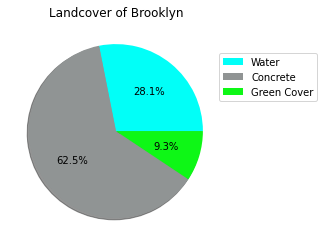

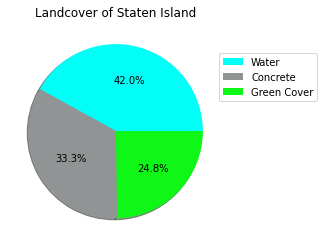

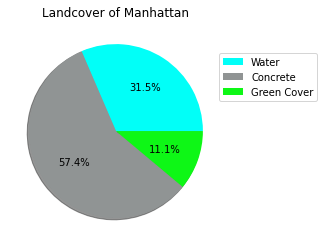

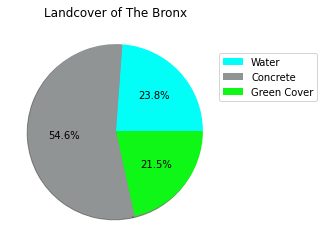

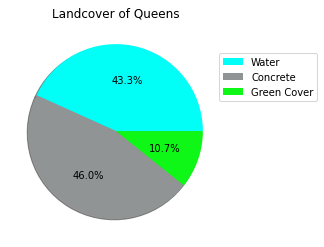

In [19]:
all_together(bk_df,'Brooklyn')
all_together(si_df,'Staten Island')
all_together(m_df,'Manhattan')
all_together(tb_df,'The Bronx')
all_together(q_df,'Queens')

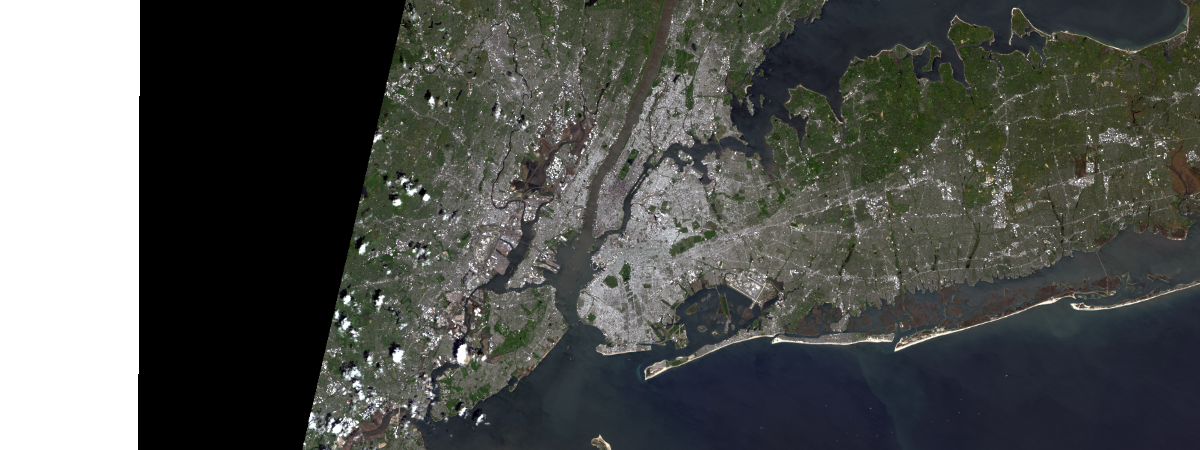

In [13]:
apply(nyc_image, 'Natural Color with DRA')

In [20]:
bkln_poly = bk_df.iloc[0].SHAPE
bkln_clip = clip(nyc_colorized,bkln_poly)
bkln_clip.extent = area['extent']

stis_poly = si_df.iloc[0].SHAPE
stis_clip = clip(nyc_colorized,stis_poly)
stis_clip.extent = area['extent']

mhtn_poly = m_df.iloc[0].SHAPE
mhtn_clip = clip(nyc_colorized,mhtn_poly)
mhtn_clip.extent = area['extent']

thbr_poly = tb_df.iloc[0].SHAPE
thbr_clip = clip(nyc_colorized,thbr_poly)
thbr_clip.extent = area['extent']

quen_poly = q_df.iloc[0].SHAPE
quen_clip = clip(nyc_colorized,quen_poly)
quen_clip.extent = area['extent']

bkln_masked = colormap(remap(bkln_clip, 
                        input_ranges=[-1,0,     # water
                                     -0.1, 0.4, # Concrete
                                     0.4, 1],   # Vegetation, Trees      
                        output_values=[1, 2, 3]),
                        colormap=[[1, 1, 255, 248], [2, 144, 148, 148], [3,14,247,22]], astype='u8')

quen_masked = colormap(remap(quen_clip, 
                        input_ranges=[-1,0,     # water
                                     -0.1, 0.4, # Concrete
                                     0.4, 1],   # Vegetation, Trees      
                        output_values=[1, 2, 3]),
                        colormap=[[1, 1, 255, 248], [2, 144, 148, 148], [3,14,247,22]], astype='u8')

mhtn_masked = colormap(remap(mhtn_clip, 
                        input_ranges=[-1,0,     # water
                                     -0.1, 0.4, # Concrete
                                     0.4, 1],   # Vegetation, Trees      
                        output_values=[1, 2, 3]),
                        colormap=[[1, 1, 255, 248], [2, 144, 148, 148], [3,14,247,22]], astype='u8')

thbr_masked = colormap(remap(thbr_clip, 
                        input_ranges=[-1,0,     # water
                                     -0.1, 0.4, # Concrete
                                     0.4, 1],   # Vegetation, Trees      
                        output_values=[1, 2, 3]),
                        colormap=[[1, 1, 255, 248], [2, 144, 148, 148], [3,14,247,22]], astype='u8')

stis_masked = colormap(remap(stis_clip, 
                        input_ranges=[-1,0,     # water
                                     -0.1, 0.4, # Concrete
                                     0.4, 1],   # Vegetation, Trees      
                        output_values=[1, 2, 3]),
                        colormap=[[1, 1, 255, 248], [2, 144, 148, 148], [3,14,247,22]], astype='u8')

bkln_mask_map = gis.map('New York City')
bkln_mask_map.basemap = 'satellite'
bkln_mask_map.zoom = 9.5
bkln_mask_map.add_layer(bkln_masked)
bkln_mask_map.add_layer(quen_clip)
bkln_mask_map.add_layer(mhtn_clip)
bkln_mask_map.add_layer(thbr_clip)
bkln_mask_map.add_layer(stis_clip)

quen_mask_map = gis.map('New York City')
quen_mask_map.basemap = 'satellite'
quen_mask_map.zoom = 9.5
quen_mask_map.add_layer(bkln_clip)
quen_mask_map.add_layer(quen_masked)
quen_mask_map.add_layer(mhtn_clip)
quen_mask_map.add_layer(thbr_clip)
quen_mask_map.add_layer(stis_clip)

mhtn_mask_map = gis.map('New York City')
mhtn_mask_map.basemap = 'satellite'
mhtn_mask_map.zoom = 9.5
mhtn_mask_map.add_layer(bkln_clip)
mhtn_mask_map.add_layer(quen_clip)
mhtn_mask_map.add_layer(mhtn_masked)
mhtn_mask_map.add_layer(thbr_clip)
mhtn_mask_map.add_layer(stis_clip)

thbr_mask_map = gis.map('New York City')
thbr_mask_map.basemap = 'satellite'
thbr_mask_map.zoom = 9.5
thbr_mask_map.add_layer(bkln_clip)
thbr_mask_map.add_layer(quen_clip)
thbr_mask_map.add_layer(mhtn_clip)
thbr_mask_map.add_layer(thbr_masked)
thbr_mask_map.add_layer(stis_clip)

stis_mask_map = gis.map('New York City')
stis_mask_map.basemap = 'satellite'
stis_mask_map.zoom = 9.5
stis_mask_map.add_layer(bkln_clip)
stis_mask_map.add_layer(quen_clip)
stis_mask_map.add_layer(mhtn_clip)
stis_mask_map.add_layer(thbr_clip)
stis_mask_map.add_layer(stis_masked)

In [25]:
#bkln_mask_map
#quen_mask_map
#mhtn_mask_map
#thbr_mask_map
#stis_mask_map

MapView(layout=Layout(height='400px', width='100%'))